# Propeller identification
We want to charchterize the transfer function of a drone propeller (BLDC motor) by measuring a set of datapoints and applying machine learning techniques to approximate the parameters

## Collection of the data points
We collect data by interfacing the computer and the board via a serial port.
In the PC side we use the pySerial library

In [134]:
import serial   # pip install pyserial, not pip install serial !

# Serial port parameters
port = '/dev/ttyUSB0'   # Depends on the OS
baud = 115200
timeout = 1

# Open te serial port
ser = serial.Serial(port, baud, timeout=timeout)
ser.flush()

We now define two function to simplify reading and writing data via the serial port.
Note that this is specific to this particular setup.

In [135]:
# Returns a string, already decoded and polished
def my_readline():
    line = ser.readline().decode('ascii').strip()
    return line

# Writes a message, following the protocol we defined:
# <message>
def my_write(message):
    ser.write(("<"+message+">").encode())

To get the data, we first must send a message to the board to tell how to measure. We have to send:
- the command: what we want to do
- the step: the distance between each input value. Can be negative
- the number of samples per input value

After that, the board will start the test and will send back data, line by line.
Each line sent by the board is a sample, already formatted to be written in a .csv file.
While we read the data, we also write it into a .csv file to store all the samples.

In [136]:
import csv

# Given the parameters, build the message string
def build_message(command, n_samples, step):
    # The words are separated by a space
    message = " ".join([command, str(n_samples), str(step)])
    return message

# Given a message and a filename, send the message and store the data in the specified file
def get_dataset(message, filename):
    # Open the file
    file = open(filename, 'a')
    file.truncate(0)

    # Setup the csv
    csv_writer = csv.writer(file)

    # Send the command to get the measurements
    my_write(message)

    # Listen to the response
    while 1:
        # Read a line = a row of the matrix S = a sample
        line = my_readline()

        # Check if the line is empty => skip
        if line == '':
            continue

        # If there is something, I check if it is the termination message
        if line == "Finished":
            file.close()
            break

        # If I'm here it is a proper sample
        values = line.split(',')
        #print(line)
        csv_writer.writerow(values)

Finally we can collect the data

In [137]:
# Collect the data
command = 'M'   # Measure
n_samples = 1000  # How many samples do I want to average for each input value
step = 1      # Step for the input signal
filename = "Dataset.csv"
get_dataset(build_message(command, n_samples, step), filename)

## Plot
After collecting the data, we draw a beautiful plot.

Before actually drawing the plot, we have to get the data from the file we created

In [138]:
import pandas
data_frame = pandas.read_csv(filename)
print(data_frame.head())

   PWM   RPM  Voltage  Current  Force
0  0.0   9.0     40.0    184.0    9.0
1  1.0   2.3     40.0    186.0    0.6
2  2.0   7.6     45.0    181.0    9.2
3  3.0   0.9     43.0    181.0    1.8
4  4.0  10.2     46.0    182.0    2.4


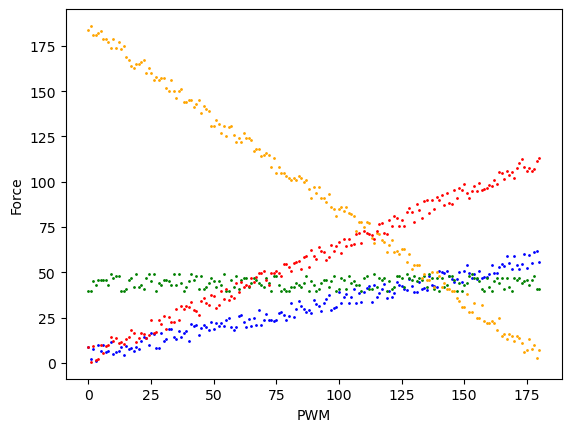

In [139]:
# https://matplotlib.org/stable/tutorials/introductory/quick_start.html#sphx-glr-tutorials-introductory-quick-start-py
import matplotlib as mpl
import matplotlib.pyplot as plt

axes = data_frame.plot(x='PWM', y='RPM', kind='scatter', s=1, c='blue')
data_frame.plot(x='PWM', y='Voltage', kind='scatter', s=1, c='green', ax=axes)
data_frame.plot(x='PWM', y='Current', kind='scatter', s=1, c='orange', ax=axes)
data_frame.plot(x='PWM', y='Force', kind='scatter', s=1, c='red', ax=axes)
plt.show()